In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

In [2]:
# importing packages
import os, sys
import pandas as pd
import numpy as np
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette("winter_r")
pd.options.display.max_rows = 300

time: 5.27 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.97 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 659 µs


### Database ERD

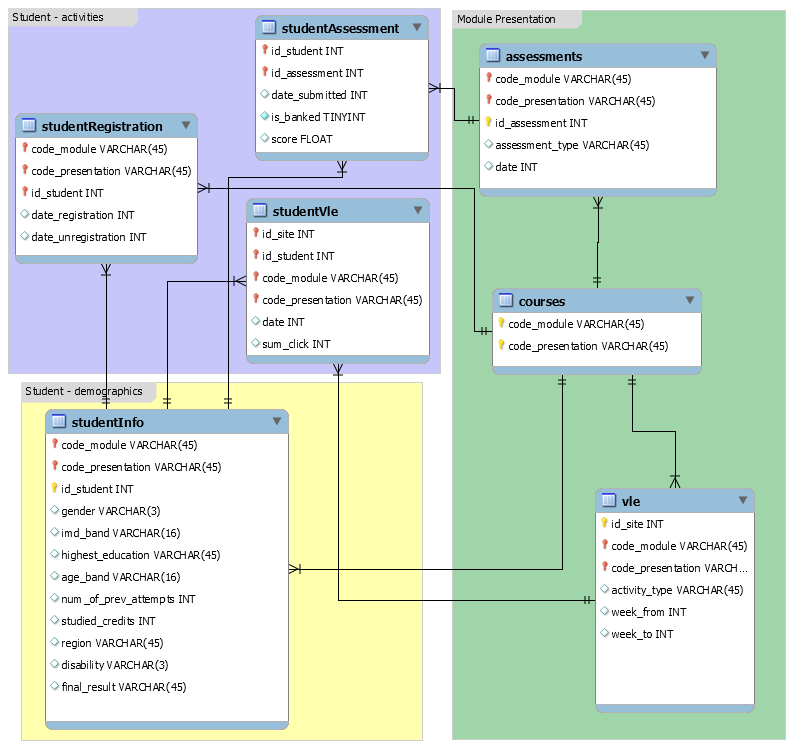

time: 3.3 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [7]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))

time: 878 µs


In [8]:
# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('f1', 'recall', 'precision'))

time: 2.98 ms


# STUDENTINFO Table

In [9]:
db.table_info('STUDENTINFO')

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'TEXT', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'TEXT', 0, None, 0),
 (9, 'studied_credits', 'TEXT', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

time: 3.11 ms


## Creating STUDENTINFO Data Frame

In [10]:
df = db.student_info()

time: 5.51 s


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31482 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                31482 non-null  int64   
 1   code_module           31482 non-null  object  
 2   code_presentation     31482 non-null  object  
 3   gender                31482 non-null  object  
 4   region                31482 non-null  object  
 5   highest_education     31482 non-null  object  
 6   imd_band              31482 non-null  object  
 7   age_band              31482 non-null  object  
 8   num_of_prev_attempts  31482 non-null  object  
 9   disability            31482 non-null  object  
 10  course_load           31482 non-null  category
dtypes: category(1), int64(1), object(9)
memory usage: 2.7+ MB
time: 25.9 ms


In [12]:
df.target.value_counts(normalize=True)

0    0.534496
1    0.465504
Name: target, dtype: float64

time: 3.54 ms


## Creating Holdout Data

In [13]:
X, y = f.X_y(df)

time: 4.4 ms


In [14]:
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 15.2 ms


## Creating Training Data

In [15]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 15.7 ms


## Baseline Model: Dummy Classifier

In [16]:
dummy = DummyClassifier(strategy='most_frequent')

time: 781 µs


In [17]:
baseline = make_pipeline(preprocessing_ohe, dummy)

time: 768 µs


### Fitting Model

In [18]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('dummyclassifier', DummyClassifier(strategy='most_frequent'))])

time: 74.1 ms


### Saving Model

In [19]:
# f.pickle_model(baseline, 'baseline')

time: 537 µs


### Cross Val Scores

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    modeling.report(baseline, X_train, y_train, ' Baseline', 'Dummy')

 Baseline has an average F1 of 0.0
 Baseline has an average Recall of 0.0
 Baseline has an average Precision of 0.0
time: 316 ms


### Test Data Confusion Matrix

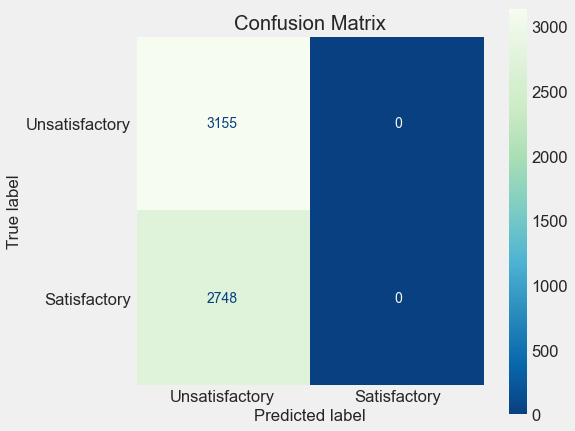

,F1,Recall,Precision
0,0.0,0.0,0.0


time: 220 ms


In [21]:
%%capture --no-display
f.confusion_report(baseline, X_test, y_test)

## First Simple Model: Naive Bayes Classifier

In [22]:
mnb = MultinomialNB()

time: 639 µs


In [23]:
fsm = make_pipeline(preprocessing_ohe, mnb)

time: 742 µs


### Fitting Model

In [24]:
fsm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('multinomialnb', MultinomialNB())])

time: 74 ms


### Saving Model

In [25]:
# f.pickle_model(fsm, 'fsm')

time: 718 µs


### Cross Val Scores

In [26]:
# checking cross val scores
modeling.report(fsm, X_train, y_train, ' fsm', 'Naive Bayes')

 fsm has an average F1 of 0.5584750581520643
 fsm has an average Recall of 0.5252959280999958
 fsm has an average Precision of 0.5962668280260026


[0.5584750581520643, 0.5252959280999958, 0.5962668280260026]

time: 355 ms


### Test Data Confusion Matrix

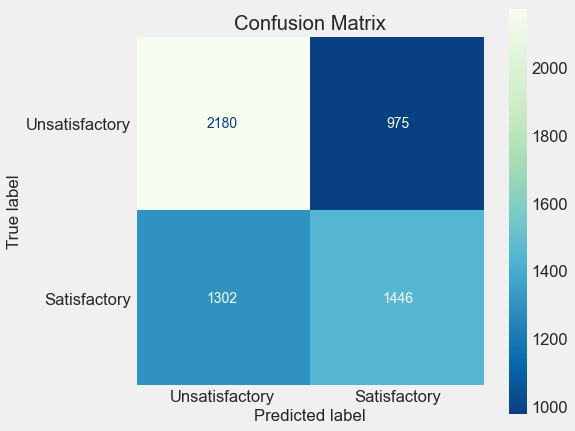

,F1,Recall,Precision
0,0.559489,0.526201,0.597274


time: 198 ms


In [27]:
f.confusion_report(fsm, X_test, y_test)

## KNeighborsClassifier

In [28]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 771 µs


In [29]:
knn = make_pipeline(preprocessing_ohe, KNN)

time: 745 µs


### Fitting Model

In [30]:
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 72.8 ms


In [31]:
# f.pickle_model(knn, 'knn')

time: 827 µs


### Cross Val Scores

In [32]:
# checking cross val scores
modeling.report(knn, X_train, y_train, 'knn', 'KNN')

knn has an average F1 of 0.5205299956194078
knn has an average Recall of 0.5097668048302295
knn has an average Precision of 0.5317915119904593


[0.5205299956194078, 0.5097668048302295, 0.5317915119904593]

time: 8.04 s


### Test Data Confusion Matrix

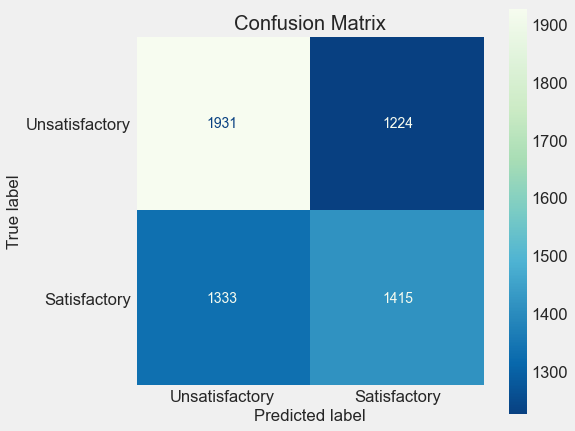

,F1,Recall,Precision
0,0.525339,0.51492,0.536188


time: 13.9 s


In [33]:
f.confusion_report(knn, X_test, y_test)

## Logistic Regression Classifier

In [34]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

time: 1.01 ms


In [35]:
logreg = make_pipeline(preprocessing_ohe, LR)

time: 850 µs


### Fitting Model

In [36]:
logreg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

time: 5.16 s


In [37]:
# f.pickle_model(logreg, 'logreg')

time: 654 µs


### Cross Val Scores

In [38]:
# checking cross val scores
modeling.report(logreg, X_train, y_train, 'logreg', 'Logistic Regression')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


logreg has an average F1 of 0.5568065871980649
logreg has an average Recall of 0.5200780702632368
logreg has an average Precision of 0.5992637500035551


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


[0.5568065871980649, 0.5200780702632368, 0.5992637500035551]

time: 7.72 s


### Test Data Confusion Matrix

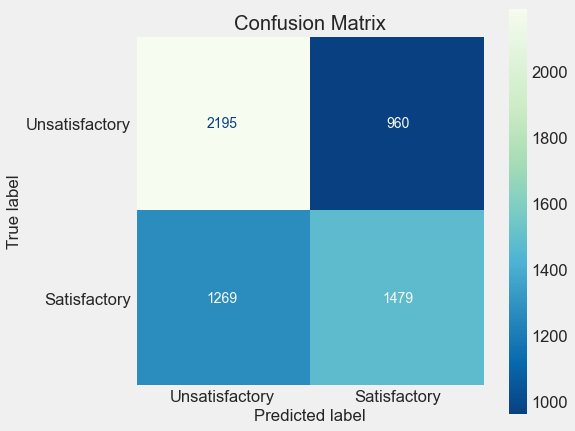

,F1,Recall,Precision
0,0.570272,0.53821,0.606396


time: 203 ms


In [39]:
f.confusion_report(logreg, X_test, y_test)

## Support Vector Machine

In [40]:
SVC = SVC()

time: 1.05 ms


In [41]:
svc = make_pipeline(preprocessing_ohe, SVC)

time: 789 µs


### Fitting Model

In [42]:
svc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('svc', SVC())])

time: 19.5 s


In [43]:
# f.pickle_model(svc, 'svc')

time: 713 µs


### Cross Val Scores

In [44]:
# checking cross val scores
modeling.report(svc, X_train, y_train, 'svc', 'Support Vector Classifier')

svc has an average F1 of 0.5578897065175143
svc has an average Recall of 0.5280843200056522
svc has an average Precision of 0.5916273931245771


[0.5578897065175143, 0.5280843200056522, 0.5916273931245771]

time: 1min 21s


### Test Data Confusion Matrix

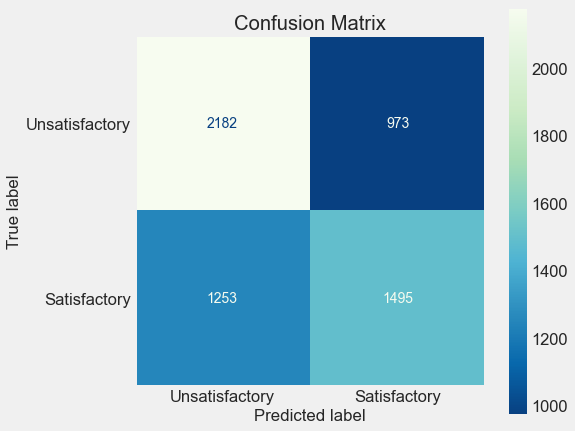

,F1,Recall,Precision
0,0.573236,0.544032,0.605754


time: 22 s


In [45]:
f.confusion_report(svc, X_test, y_test)

## Linear Support Vector Machine

In [46]:
LSVC = LinearSVC()

time: 963 µs


In [47]:
lsvc = make_pipeline(preprocessing_ohe, LSVC)

time: 1.07 ms


### Fitting Model

In [48]:
lsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('linearsvc', LinearSVC())])

time: 492 ms


In [49]:
# f.pickle_model(lsvc, 'lsvc')

time: 1.06 ms


### Cross Val Scores

In [50]:
# checking cross val scores
modeling.report(lsvc, X_train, y_train, 'lsvc', 'Linear SVC')

lsvc has an average F1 of 0.5571728773969994
lsvc has an average Recall of 0.5205634335607929
lsvc has an average Precision of 0.599481066526603


[0.5571728773969994, 0.5205634335607929, 0.599481066526603]

time: 1.84 s


### Test Data Confusion Matrix

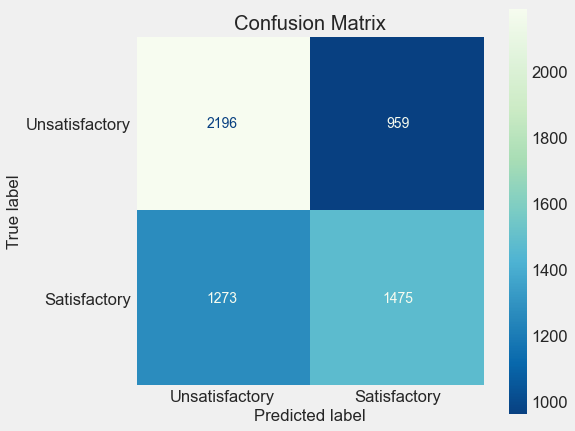

,F1,Recall,Precision
0,0.569278,0.536754,0.605998


time: 336 ms


In [51]:
f.confusion_report(lsvc, X_test, y_test)

## Decision Tree

In [52]:
DT = DecisionTreeClassifier(random_state=2021)

time: 1.2 ms


In [53]:
dt = make_pipeline(preprocessing_ohe, DT)

time: 1.4 ms


### Fitting Model

In [54]:
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 769 ms


In [55]:
# f.pickle_model(dt, 'dt')

time: 1.34 ms


### Cross Val Scores

In [56]:
# checking cross val scores
modeling.report(dt, X_train, y_train, 'dt', 'Decision Tree')

dt has an average F1 of 0.47922863972403074
dt has an average Recall of 0.45383801303526117
dt has an average Precision of 0.507737322013517


[0.47922863972403074, 0.45383801303526117, 0.507737322013517]

time: 2.48 s


### Test Data Confusion Matrix

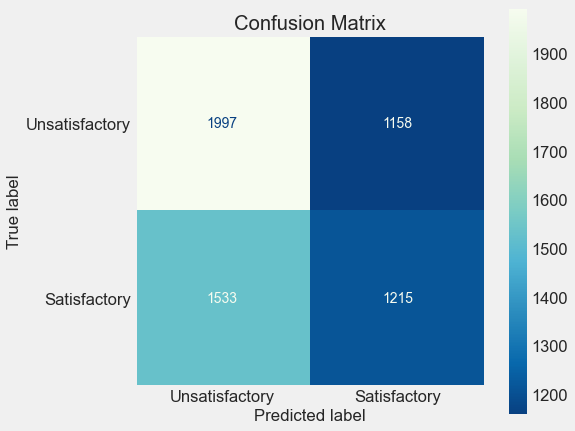

,F1,Recall,Precision
0,0.474517,0.44214,0.51201


time: 302 ms


In [57]:
f.confusion_report(dt, X_test, y_test)

## Bagging Classifier

In [58]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 1.15 ms


In [59]:
bclf = make_pipeline(preprocessing_ohe, BCLF)

time: 1.7 ms


### Fitting Model

In [60]:
bclf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 4.53 s


In [61]:
# f.pickle_model(bclf, 'bclf')

time: 703 µs


### Cross Val Scores

In [62]:
# checking cross val scores
modeling.report(bclf, X_train, y_train, 'bclf', 'Bagging CLF')

bclf has an average F1 of 0.5054504013987768
bclf has an average Recall of 0.48841383715932574
bclf has an average Precision of 0.523763183365993


[0.5054504013987768, 0.48841383715932574, 0.523763183365993]

time: 13.9 s


### Test Data Confusion Matrix

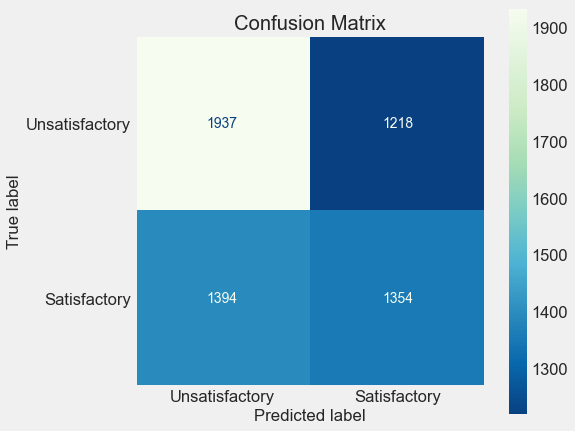

,F1,Recall,Precision
0,0.509023,0.492722,0.526439


time: 355 ms


In [63]:
f.confusion_report(bclf, X_test, y_test)

## Random Forest Classifier

In [64]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 1.06 ms


In [65]:
rf = make_pipeline(preprocessing_ohe, RF)

time: 1.17 ms


### Fitting Model

In [66]:
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 4.13 s


In [67]:
# f.pickle_model(rf, 'rf')

time: 668 µs


### Cross Val Scores

In [68]:
# checking cross val scores
modeling.report(rf, X_train, y_train, 'rf', 'Random Forest')

rf has an average F1 of 0.5263073651414387
rf has an average Recall of 0.5135257761397021
rf has an average Precision of 0.5398162966900563


[0.5263073651414387, 0.5135257761397021, 0.5398162966900563]

time: 18.3 s


### Test Data Confusion Matrix

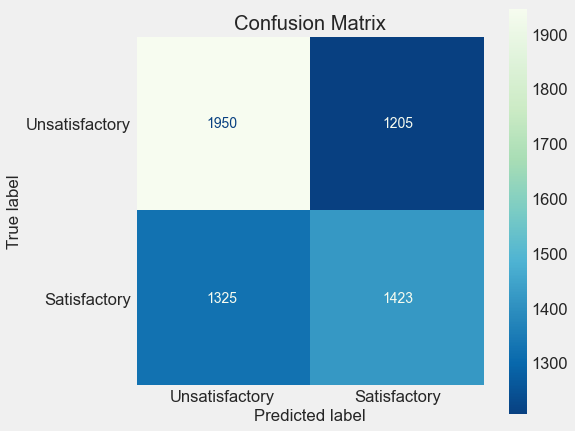

,F1,Recall,Precision
0,0.52939,0.517831,0.541476


time: 545 ms


In [69]:
f.confusion_report(rf, X_test, y_test)

## AdaBoost

In [70]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 1.28 ms


In [71]:
ada = make_pipeline(preprocessing_ohe, ADA)

time: 1.09 ms


### Fitting Model

In [72]:
ada.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 3.04 s


In [73]:
# f.pickle_model(ada, 'ada')

time: 687 µs


### Cross Val Scores

In [74]:
# checking cross val scores
modeling.report(ada, X_train, y_train, 'ada', 'AdaBoost')

ada has an average F1 of 0.5060937328903256
ada has an average Recall of 0.4964170694801792
ada has an average Precision of 0.5165798639385684


[0.5060937328903256, 0.4964170694801792, 0.5165798639385684]

time: 12.1 s


### Test Data Confusion Matrix

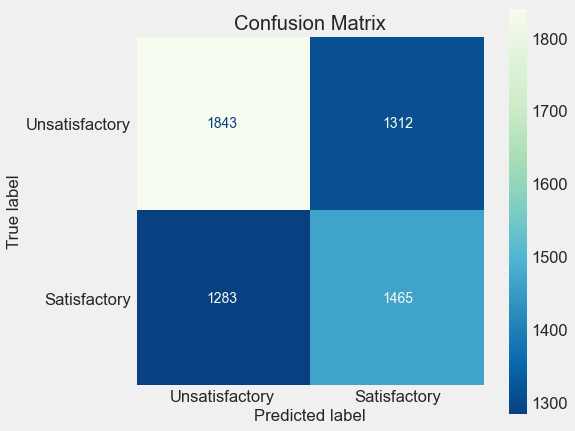

,F1,Recall,Precision
0,0.530317,0.533115,0.527548


time: 429 ms


In [75]:
f.confusion_report(ada, X_test, y_test)

## XGBoost

In [76]:
XGB = XGBClassifier(use_label_encoder=False)

time: 1.15 ms


In [77]:
xgb = make_pipeline(preprocessing_ohe, XGB)

time: 1.1 ms


### Fitting Model

In [78]:
%%capture --no-display
xgb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               impo...pe='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
            

time: 691 ms


In [79]:
# f.pickle_model(xgb, 'xgb')

time: 786 µs


### Cross Val Scores

In [80]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb, X_train, y_train, 'xgb', 'XGBoost')

[0.542734555699536, 0.5239571496699971, 0.5632411485058106]

time: 3.13 s


### Test Data Confusion Matrix

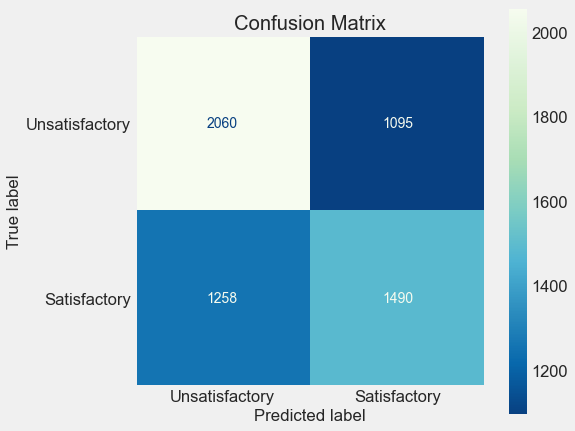

,F1,Recall,Precision
0,0.558785,0.542213,0.576402


time: 351 ms


In [81]:
%%capture --no-display
f.confusion_report(xgb, X_test, y_test)

In [82]:
modeling.history

,Name,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.000000,0.000000,0.000000,0.313518,Dummy
1,dt,0.479229,0.453838,0.507737,2.476792,Decision Tree
2,bclf,0.505450,0.488414,0.523763,13.906625,Bagging CLF
3,ada,0.506094,0.496417,0.516580,12.045153,AdaBoost
4,knn,0.520530,0.509767,0.531792,8.025599,KNN
5,rf,0.526307,0.513526,0.539816,18.263699,Random Forest
10,xgb,0.542735,0.523957,0.563241,3.127783,XGBoost
6,logreg,0.556807,0.520078,0.599264,7.711932,Logistic Regression
7,lsvc,0.557173,0.520563,0.599481,1.833334,Linear SVC
8,svc,0.557890,0.528084,0.591627,81.321887,Support Vector Classifier


time: 13.5 ms


# STUDENTINFO & STUDENTVLE

In [83]:
df = db.sv_si()

time: 36.9 s


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28174 entries, 0 to 29227
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                28174 non-null  int64   
 1   code_module           28174 non-null  object  
 2   code_presentation     28174 non-null  object  
 3   click_sum             28174 non-null  int64   
 4   num_activities        28174 non-null  int64   
 5   gender                28174 non-null  object  
 6   region                28174 non-null  object  
 7   highest_education     28174 non-null  object  
 8   imd_band              28174 non-null  object  
 9   age_band              28174 non-null  object  
 10  num_of_prev_attempts  28174 non-null  int64   
 11  disability            28174 non-null  object  
 12  course_load           28174 non-null  category
dtypes: category(1), int64(4), object(8)
memory usage: 2.8+ MB
time: 27.3 ms


In [85]:
df.head()

,target,code_module,code_presentation,click_sum,num_activities,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,course_load
0,1,AAA,2013J,744,243,Male,Yorkshire Region,A Level or Equivalent,20-30%,0-35,0,No,Light
1,1,AAA,2013J,4104,913,Male,South Region,Lower Than A Level,80-90%,35-55,0,No,Light
2,1,AAA,2013J,1944,781,Male,North Western Region,A Level or Equivalent,30-40%,0-35,0,No,Light
3,1,AAA,2013J,1150,313,Male,London Region,HE Qualification,60-70%,0-35,0,No,Light
4,1,AAA,2013J,1896,572,Female,London Region,Lower Than A Level,30-40%,35-55,0,No,Light


time: 11.6 ms


In [86]:
df.describe()

,target,click_sum,num_activities,num_of_prev_attempts
count,28174.000000,28174.000000,28174.000000,28174.000000
mean,0.520054,1326.499219,356.832363,0.160006
std,0.499607,1713.634452,374.100510,0.475827
min,0.000000,1.000000,1.000000,0.000000
25%,0.000000,252.000000,91.000000,0.000000
50%,1.000000,717.000000,235.000000,0.000000
75%,1.000000,1722.000000,496.000000,0.000000
max,1.000000,24139.000000,3078.000000,6.000000


time: 23.5 ms


## Creating Holdout Data

In [87]:
X, y = f.X_y(df)

time: 7.23 ms


In [88]:
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 22.7 ms


## Creating Training Data

In [89]:
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 21.4 ms


## MinMax Scaling
Since we've added numerical columns to the data, we'll test some scaling in the pipeline. K-Nearest Neighbors in particular is sensitive to differences in feature scale, and scaling can also help speed up convergence is certain algorithms.

## Naive Bayes Classifier

In [90]:
mnb_svsi = make_pipeline(preprocessing_mm, mnb)

time: 941 µs


### Fitting Model

In [91]:
mnb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('multinomialnb', MultinomialNB())])

time: 82.2 ms


### Saving Model

In [92]:
# f.pickle_model(mnb_svsi, 'mnb_svsi')

time: 587 µs


### Cross Val Scores

In [93]:
# checking cross val scores
modeling.report(mnb_svsi, X_train, y_train, ' mnb_svsi', 'Naive Bayes SVSI/MinMax()')

 mnb_svsi has an average F1 of 0.701241283960963
 mnb_svsi has an average Recall of 0.7252748061490635
 mnb_svsi has an average Precision of 0.6788375700243776


[0.701241283960963, 0.7252748061490635, 0.6788375700243776]

time: 413 ms


### Test Data Confusion Matrix

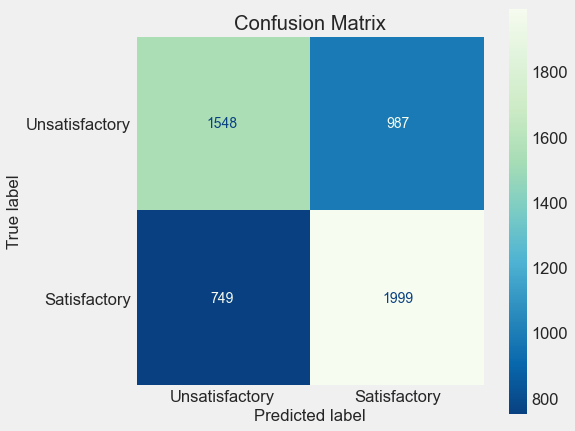

,F1,Recall,Precision
0,0.697245,0.727438,0.669457


time: 247 ms


In [94]:
f.confusion_report(mnb_svsi, X_test, y_test)

## KNeighborsClassifier

In [95]:
knn_svsi = make_pipeline(preprocessing_mm, KNN)

time: 932 µs


### Fitting Model

In [96]:
knn_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 84.2 ms


In [97]:
# f.pickle_model(knn_svsi, 'knn_svsi')

time: 687 µs


### Cross Val Scores

In [98]:
# checking cross val scores
modeling.report(knn_svsi, X_train, y_train, 'knn_svsi', 'KNN SVSI/MinMax()')

knn_svsi has an average F1 of 0.7391469699856765
knn_svsi has an average Recall of 0.7408090075185314
knn_svsi has an average Precision of 0.7375013312332741


[0.7391469699856765, 0.7408090075185314, 0.7375013312332741]

time: 8.14 s


### Test Data Confusion Matrix

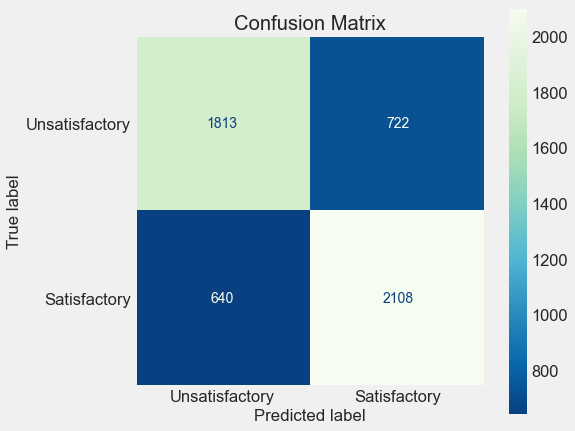

,F1,Recall,Precision
0,0.755826,0.767103,0.744876


time: 14.4 s


In [99]:
f.confusion_report(knn_svsi, X_test, y_test)

## Logistic Regression Classifier

In [100]:
logreg_svsi = make_pipeline(preprocessing_mm, LR)

time: 878 µs


### Fitting Model

In [101]:
logreg_svsi.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

time: 579 ms


In [102]:
# f.pickle_model(logreg_svsi, 'logreg_svsi')

time: 713 µs


### Cross Val Scores

In [103]:
# checking cross val scores
modeling.report(logreg_svsi, X_train, y_train, 'logreg_svsi', 'LR SVSI/MinMax()')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


logreg_svsi has an average F1 of 0.8184801511385398
logreg_svsi has an average Recall of 0.8052417028266617
logreg_svsi has an average Precision of 0.8322252250837672


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


[0.8184801511385398, 0.8052417028266617, 0.8322252250837672]

time: 2.13 s


### Test Data Confusion Matrix

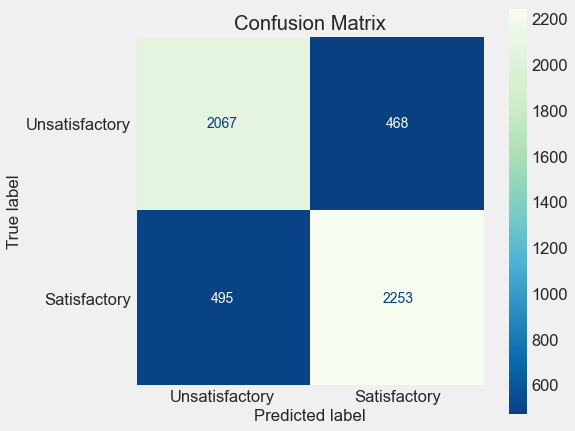

,F1,Recall,Precision
0,0.823917,0.819869,0.828004


time: 219 ms


In [104]:
f.confusion_report(logreg_svsi, X_test, y_test)

## Support Vector Machine

In [105]:
svc_svsi= make_pipeline(preprocessing_mm, SVC)

time: 984 µs


### Fitting Model

In [106]:
svc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('svc', SVC())])

time: 12.9 s


In [107]:
# f.pickle_model(svc, 'svc_svsi')

time: 591 µs


### Cross Val Scores

In [108]:
# checking cross val scores
modeling.report(svc_svsi, X_train, y_train, 'svc_svsi', 'SVC SVSI/MinMax()')

svc_svsi has an average F1 of 0.7910783583129153
svc_svsi has an average Recall of 0.7847347171277679
svc_svsi has an average Precision of 0.7975555543908864


[0.7910783583129153, 0.7847347171277679, 0.7975555543908864]

time: 49.8 s


### Test Data Confusion Matrix

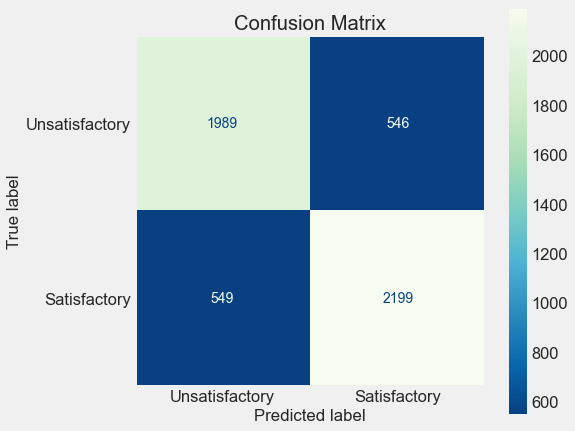

,F1,Recall,Precision
0,0.800655,0.800218,0.801093


time: 12.6 s


In [109]:
f.confusion_report(svc_svsi, X_test, y_test)

## Linear Support Vector Machine

In [110]:
lsvc_svsi = make_pipeline(preprocessing_mm, LSVC)

time: 833 µs


### Fitting Model

In [111]:
lsvc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('linearsvc', LinearSVC())])

time: 347 ms


In [112]:
# f.pickle_model(lsvc_svsi, 'lsvc_svsi')

time: 609 µs


### Cross Val Scores

In [113]:
# checking cross val scores
modeling.report(lsvc_svsi, X_train, y_train, 'lsvc_svsi', 'Linear SVC SVSI/MinMax()')

lsvc_svsi has an average F1 of 0.8161024645428349
lsvc_svsi has an average Recall of 0.799538776074938
lsvc_svsi has an average Precision of 0.8334493246283519


[0.8161024645428349, 0.799538776074938, 0.8334493246283519]

time: 1.09 s


### Test Data Confusion Matrix

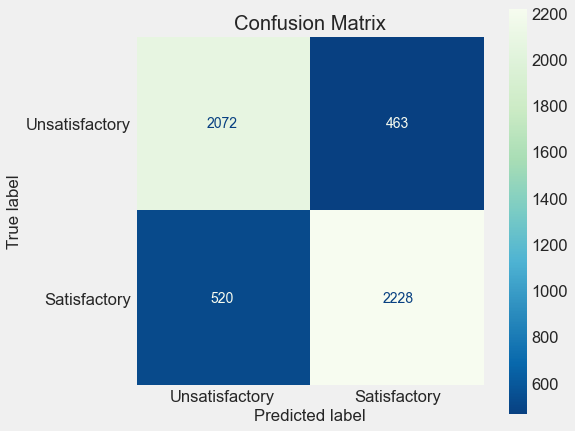

,F1,Recall,Precision
0,0.819268,0.810771,0.827945


time: 225 ms


In [114]:
f.confusion_report(lsvc_svsi, X_test, y_test)

## Decision Tree

In [115]:
dt_svsi = make_pipeline(preprocessing_mm, DT)

time: 1.11 ms


### Fitting Model

In [116]:
dt_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 568 ms


In [117]:
# f.pickle_model(dt_svsi, 'dt_svsi')

time: 682 µs


### Cross Val Scores

In [118]:
# checking cross val scores
modeling.report(dt_svsi, X_train, y_train, 'dt_svsi', 'DT SVSI/MinMax()')

dt_svsi has an average F1 of 0.7764258626602372
dt_svsi has an average Recall of 0.7752705376014883
dt_svsi has an average Precision of 0.7777166568998316


[0.7764258626602372, 0.7752705376014883, 0.7777166568998316]

time: 2.25 s


### Test Data Confusion Matrix

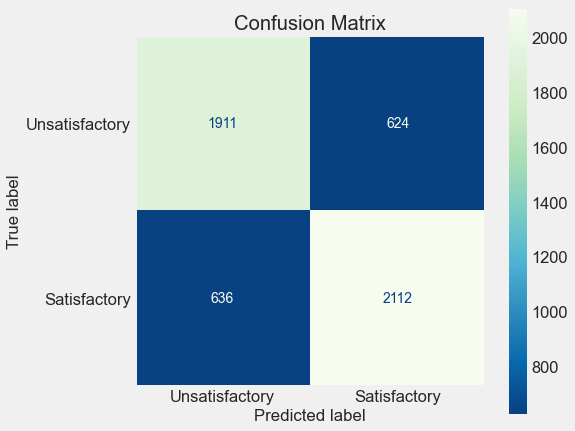

,F1,Recall,Precision
0,0.770241,0.768559,0.77193


time: 242 ms


In [119]:
f.confusion_report(dt_svsi, X_test, y_test)

## Bagging Classifier

In [120]:
bclf_svsi = make_pipeline(preprocessing_mm, BCLF)

time: 893 µs


### Fitting Model

In [121]:
bclf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.2 s


In [122]:
# f.pickle_model(bclf_svsi, 'bclf_svsi')

time: 753 µs


### Cross Val Scores

In [123]:
# checking cross val scores
modeling.report(bclf_svsi, X_train, y_train, 'bclf_svsi', 'BCLF SVSI/MinMax()')

bclf_svsi has an average F1 of 0.8160144135466766
bclf_svsi has an average Recall of 0.8182259621895
bclf_svsi has an average Precision of 0.8138526729148797


[0.8160144135466766, 0.8182259621895, 0.8138526729148797]

time: 11.5 s


### Test Data Confusion Matrix

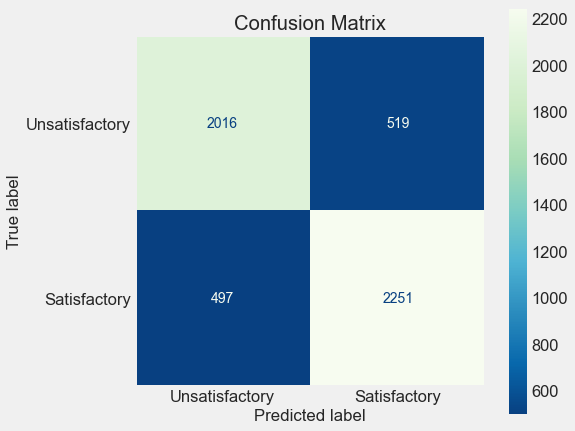

,F1,Recall,Precision
0,0.815875,0.819141,0.812635


time: 279 ms


In [124]:
f.confusion_report(bclf_svsi, X_test, y_test)

## Random Forest Classifier

In [125]:
rf_svsi = make_pipeline(preprocessing_mm, RF)

time: 900 µs


### Fitting Model

In [126]:
rf_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.51 s


In [127]:
# f.pickle_model(rf_svsi, 'rf_svsi')

time: 683 µs


### Cross Val Scores

In [128]:
# checking cross val scores
modeling.report(rf_svsi, X_train, y_train, 'rf_svsi', 'RF SVSI/MinMax()')

rf_svsi has an average F1 of 0.8372606217069951
rf_svsi has an average Recall of 0.8677348584314117
rf_svsi has an average Precision of 0.808875126638992


[0.8372606217069951, 0.8677348584314117, 0.808875126638992]

time: 10.9 s


### Test Data Confusion Matrix

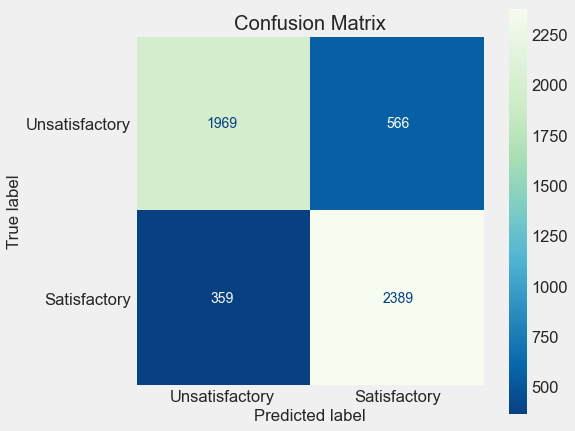

,F1,Recall,Precision
0,0.837805,0.86936,0.80846


time: 470 ms


In [129]:
f.confusion_report(rf_svsi, X_test, y_test)

## AdaBoost

In [130]:
ada_svsi = make_pipeline(preprocessing_mm, ADA)

time: 997 µs


### Fitting Model

In [131]:
ada_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 652 ms


In [132]:
# f.pickle_model(ada_svsi, 'ada_svsi')

time: 603 µs


### Cross Val Scores

In [133]:
# checking cross val scores
modeling.report(ada_svsi, X_train, y_train, 'ada_svsi', 'ADA SVSI/MinMax()')

ada_svsi has an average F1 of 0.7776936776497783
ada_svsi has an average Recall of 0.777818566121274
ada_svsi has an average Precision of 0.7777347788903144


[0.7776936776497783, 0.777818566121274, 0.7777347788903144]

time: 2.26 s


### Test Data Confusion Matrix

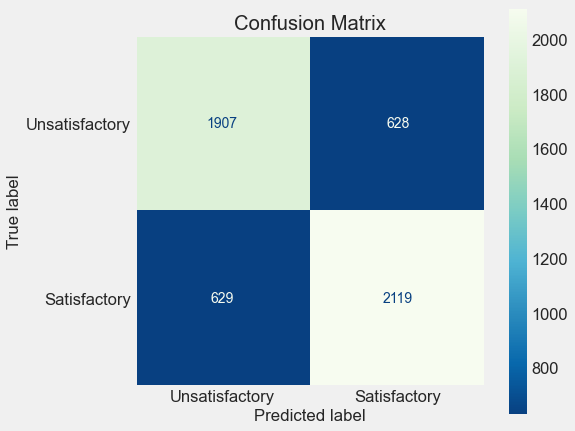

,F1,Recall,Precision
0,0.771247,0.771106,0.771387


time: 237 ms


In [134]:
f.confusion_report(ada_svsi, X_test, y_test)

## XGBoost

In [135]:
xgb_svsi = make_pipeline(preprocessing_mm, XGB)

time: 1.04 ms


### Fitting Model

In [136]:
%%capture --no-display
xgb_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('xgbclassifier',
                 XGBClassifier(ba...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 1.18 s


In [137]:
# f.pickle_model(xgb_svsi, 'xgb_svsi')

time: 821 µs


### Cross Val Scores

In [138]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_svsi, X_train, y_train, 'xgb_svsi', 'XGB SVSI/MinMax()')

[0.8391279115194916, 0.8734373436092483, 0.8074373672073328]

time: 5.26 s


### Test Data Confusion Matrix

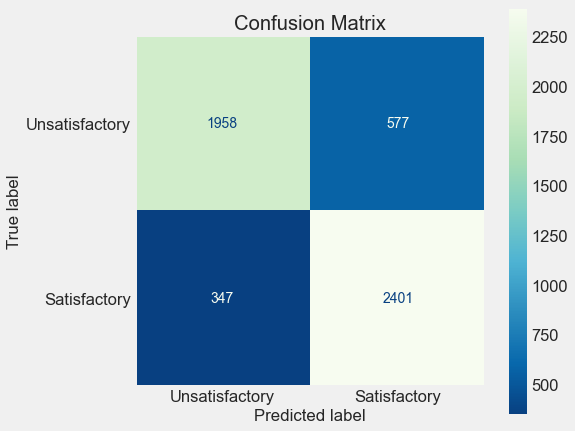

,F1,Recall,Precision
0,0.838631,0.873726,0.806246


time: 362 ms


In [139]:
%%capture --no-display
f.confusion_report(xgb_svsi, X_test, y_test)

## Initial Modeling Summary

In [140]:
modeling.history

,Name,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.000000,0.000000,0.000000,0.313518,Dummy
1,dt,0.479229,0.453838,0.507737,2.476792,Decision Tree
2,bclf,0.505450,0.488414,0.523763,13.906625,Bagging CLF
3,ada,0.506094,0.496417,0.516580,12.045153,AdaBoost
4,knn,0.520530,0.509767,0.531792,8.025599,KNN
5,rf,0.526307,0.513526,0.539816,18.263699,Random Forest
6,xgb,0.542735,0.523957,0.563241,3.127783,XGBoost
7,logreg,0.556807,0.520078,0.599264,7.711932,Logistic Regression
8,lsvc,0.557173,0.520563,0.599481,1.833334,Linear SVC
9,svc,0.557890,0.528084,0.591627,81.321887,Support Vector Classifier


time: 13.2 ms


### Voting Classifier

In [141]:
clf1 = LR
clf2 = RF
clf3 = XGB

estimators = [('lsvs',clf1), ('logreg', clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.16 ms


In [142]:
vc_svsi = make_pipeline(preprocessing_mm, VC)

time: 1.08 ms


### Fitting Model

In [143]:
%%capture --no-display
vc_svsi.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2ee0>),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1868b2d60>)])),
                ('votingclassifier',
                 VotingClassif...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 4.41 s


In [144]:
# f.pickle_model(vc_svsi, 'vc_svsi')

time: 678 µs


### Cross Val Scores

In [145]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_svsi, X_train, y_train, 'vc_svsi', 'VC SVSI/MinMax()')

[0.8208322248104176, 0.7965045011098224, 0.8467768212497038]

time: 17.2 s


### Test Data Confusion Matrix

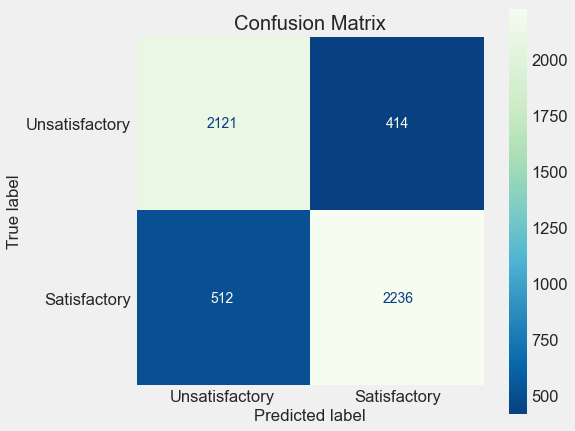

,F1,Recall,Precision
0,0.828455,0.813683,0.843774


time: 783 ms


In [146]:
%%capture --no-display
f.confusion_report(vc_svsi, X_test, y_test)

### Summary

In [147]:
modeling.history

,Name,F1,Recall,Precision,CV_Time(sec),Notes
0,Baseline,0.000000,0.000000,0.000000,0.313518,Dummy
1,dt,0.479229,0.453838,0.507737,2.476792,Decision Tree
2,bclf,0.505450,0.488414,0.523763,13.906625,Bagging CLF
3,ada,0.506094,0.496417,0.516580,12.045153,AdaBoost
4,knn,0.520530,0.509767,0.531792,8.025599,KNN
5,rf,0.526307,0.513526,0.539816,18.263699,Random Forest
6,xgb,0.542735,0.523957,0.563241,3.127783,XGBoost
7,logreg,0.556807,0.520078,0.599264,7.711932,Logistic Regression
8,lsvc,0.557173,0.520563,0.599481,1.833334,Linear SVC
9,svc,0.557890,0.528084,0.591627,81.321887,Support Vector Classifier


time: 11.4 ms
